### Load Libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
import time
import random
import os
import PIL
from numpy import loadtxt
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt


In [2]:
!pip install xgboost

distributed 1.21.8 requires msgpack, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Load Data ####

In [3]:
img_dir = "C:\\NICE\\TMF_DATA\\BITSPilani\\IITH\Classess\\7.AdvancedML\\Project\\chest_xray\\test" # Enter Directory of all images 
dirlist = [ item for item in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, item)) ]
## Load images and flatten
Normal_Image=[]
PNEUMONIA_Image=[]
basewidth=400
hsize=400
for item in dirlist:
    if(item=='NORMAL'):
            data_path = os.path.join(img_dir+'\\'+item,'*jpeg')
            files = glob.glob(data_path)
            for f1 in files:
                img = Image.open(f1)
                img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
                im_list=[item for sublist in np.array(img).tolist() for item in sublist]
                Normal_Image.append(im_list)
    elif(item=='PNEUMONIA'):
        data_path = os.path.join(img_dir+'\\'+item,'*jpeg')
        files = glob.glob(data_path)
        for f1 in files:
            img = Image.open(f1)
            img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
            im_list=[item for sublist in np.array(img).tolist() for item in sublist]
            PNEUMONIA_Image.append(im_list)

        


In [4]:
### Assign targets
Normal_target=[0] * len(Normal_Image)
PNEUMONIA_target=[1] * len(PNEUMONIA_Image)

In [5]:
Normal_Image_df=pd.DataFrame(Normal_Image)
Normal_Image_df['target']=pd.DataFrame(Normal_target)
PNEUMONIA_Image_df=pd.DataFrame(PNEUMONIA_Image)
PNEUMONIA_Image_df['target']=pd.DataFrame(PNEUMONIA_target)
print(Normal_Image_df.head())
print(PNEUMONIA_Image_df.head())

    0   1   2   3   4   5   6   7   8   9   ...    159991  159992  159993  \
0  27  34  32  31  32  33  33  32  31  31   ...        33      33      33   
1  11  38  36  33  30  28  28  25  25  48   ...        32      33      34   
2  34  38  37  38  37  36  37  37  35  34   ...        34      36      36   
3  58  76  73  73  72  74  75  74  73  77   ...       136     133     127   
4  35  42  40  40  39  40  41  38  37  40   ...        45      44      42   

   159994  159995  159996  159997  159998  159999  target  
0      34      32      32      31      35      29       0  
1      33      32      33      33      34      21       0  
2      33      34      38      34      36      30       0  
3     134     143     136     122     132     104       0  
4      45      45      44      45      47      39       0  

[5 rows x 160001 columns]
     0    1    2    3    4    5    6    7    8    9   ...    159991  159992  \
0   15   20   18   16   17   21   28   32   36   35   ...         0    

In [6]:
Final_df=pd.concat([Normal_Image_df,PNEUMONIA_Image_df])

### Probablity Distribution Wise Labeling 

In [7]:
def pdfCalculator(element,mean1,std1,mean2,std2,absCutoff=0.0005,pctCutoff=0.2,code='HLLH'):
    import scipy.stats
    prob1     = scipy.stats.norm(mean1, std1).pdf(element)
    prob2     = scipy.stats.norm(mean2, std2).pdf(element)
    diff      = (prob1-prob2)
    absDiff   = abs(diff)
    pctDiff=absDiff/prob1
    if(code=='HLLH'):
        lower_bound=mean1-std1
        upper_bound=mean1+std1
        label = np.where((diff<0)&(absDiff>absCutoff)&(element<(mean1-std1)),
                 -1,
                 np.where((diff>0)&(absDiff>absCutoff)&(element>(mean1+std1)),
                          1,
                          np.where((diff>0)&(pctDiff>pctCutoff)&(element>=lower_bound)&(element<=upper_bound),
                                   1,
                                   0
                         )
                        )
                    )
    if(code=='HHLL'):
        lower_bound=mean2-std2
        upper_bound=mean2+std2
        label = np.where((diff>0)&(absDiff>absCutoff)&(element<(mean1-1.5*std1)),
                    1,
                    np.where((diff>0)&(absDiff>absCutoff)&(element>(mean1+1.5*std1)),
                            1,
                            np.where((diff<0)&(pctDiff>pctCutoff)&(element>=lower_bound)&(element<=upper_bound),
                                -1,
                                0
                        )
                    )
                )
    if(code=='HHLH'):
        lower_bound=mean1-std1
        upper_bound=mean2+std2
        label = np.where((diff<0)&(element<mean2),
                    -1,
                    np.where((diff>0)&(element>mean1),
                            1,
                            np.where((diff<0)&(pctDiff>pctCutoff)&(element>=mean2)&(element<=upper_bound),
                                -1,
                                  np.where((diff>0)&(pctDiff>pctCutoff)&(element<=mean1)&(element>=lower_bound),
                                  1,
                                  0
                                          )
                                    )
                        )
                    )
                
    if(code=='HLLL'):
        lower_bound=mean1-1.5*std1
        upper_bound=mean2+1.5*std2
        label = np.where((diff<0)&(element<mean2),
                    -1,
                    np.where((diff>0)&(element>mean1),
                            1,
                            np.where((diff<0)&(pctDiff>pctCutoff)&(element>=mean2)&(element<=upper_bound),
                                -1,
                                  np.where((diff>0)&(pctDiff>pctCutoff)&(element<=mean1)&(element>=lower_bound),
                                  1,
                                  0
                                          )
                                    )
                        )
                    )
                
    return label

In [8]:
def labelGeneratorWithProbDist(df,e=0.3,absCutoff=0.0005,pctCutoff=0.2,nCol=3):
    import scipy.stats
    labelMasterDF = pd.DataFrame()
    subCol = random.sample(df.columns.tolist(),k=nCol)
    i=0
    for series in list(subCol):
        labelDF   = pd.DataFrame()
        median    = np.median(df[df.columns[series]])
        std       = np.std(df[df.columns[series]])
        high_mean = median + e*median
        low_std   = std    - e*std
        low_mean  = median - e*median
        high_std  = std    + e*std
        ############ Combination 1 := Probablity-1 High_Mean, Low_SD && Probablity-2 Low_Mean, High_SD ############
        
        labelDF['ProbDist_1_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,low_std,low_mean,high_std,absCutoff,pctCutoff,code='HLLH'))
        labelDF['ProbDist_2_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[0]]==0,0,np.where(labelDF[labelDF.columns[0]]==-1,1,-1))
        
        ############ Combination 2 := Probablity-1 High_Mean, High_SD && Probablity-2 Low_Mean, High_SD ############
        
        labelDF['ProbDist_3_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,high_std,low_mean,high_std,absCutoff,pctCutoff,code='HHLH'))
        #print(labelDF['ProbDist_3_Column_3'].unique())
        labelDF['ProbDist_4_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[2]]==0,0,np.where(labelDF[labelDF.columns[2]]==-1,1,-1))
        
        ############ Combination 3 := Probablity-1 High_Mean, High_SD && Probablity-2 Low_Mean, Low_SD ############

        labelDF['ProbDist_5_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,high_std,low_mean,low_std,absCutoff,pctCutoff,code='HHLL'))
        labelDF['ProbDist_6_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[4]]==0,0,np.where(labelDF[labelDF.columns[4]]==-1,1,-1))
                
        ############ Combination 4 := Probablity-1 High_Mean, Low_SD && Probablity-2 Low_Mean, Low_SD ############
        
        labelDF['ProbDist_7_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,low_std,low_mean,low_std,absCutoff,pctCutoff,code='HLLL'))
        labelDF['ProbDist_8_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[6]]==0,0,np.where(labelDF[labelDF.columns[6]]==-1,1,-1))
               
        if(i==0):
            labelMasterDF = labelDF.copy()
        else:
            labelMasterDF = pd.concat([labelMasterDF,labelDF],axis=1,sort=False)
        i=i+1 
    return labelMasterDF

In [9]:
## This function calculates different accuracy metric for labels created by probabilistic labeling function
def calculate_accuracy_metric(label_df,data_df, target_col):
    cols=label_df.columns
    Label_Name=[]
    Precision=[]
    Recall=[]
    F1=[]
    Accuracy=[]
    Coverage=[]
    for col in cols:
        a=pd.crosstab(data_df[target_col],label_df[col])
        P=a[1][1]/(a[1][1]+a[1][0])
        R=a[1][1]/(a[1][1]+a[-1][1])
        f1=2*(P*R)/(P+R)
        Acc=(a[-1][0]+a[1][1])/(a[-1][0]+a[-1][1]+a[1][0]+a[1][1])
        cvg=(a[1].sum()+a[-1].sum())/(a.sum().sum())
        Label_Name.append(col)
        Precision.append(P)
        Recall.append(R)
        F1.append(f1)
        Accuracy.append(Acc)
        Coverage.append(cvg)
    Accuracy_Metric=pd.concat([pd.DataFrame(Label_Name),pd.DataFrame(Coverage),pd.DataFrame(Precision),pd.DataFrame(Recall),pd.DataFrame(F1),pd.DataFrame(Accuracy)],axis=1)
    Accuracy_Metric.columns=['Label_Name','Coverage','Precision','Recall','F1','Accuracy']
    Accuracy_Metric=Accuracy_Metric.sort_values(by=['Coverage','Precision'],ascending=False)
    return Accuracy_Metric 


In [10]:
### generative lables with various cut-off of probability
def Gen_Label_Cutoff(train_marginals_df,marginal_col):
    train_marginals_df['labels_gen_4'] = np.where(train_marginals_df[marginal_col]>0.40, 1,0)
    train_marginals_df['labels_gen_5'] = np.where(train_marginals_df[marginal_col]>0.50, 1,0)
    train_marginals_df['labels_gen_6'] = np.where(train_marginals_df[marginal_col]>0.60, 1,0)
    train_marginals_df['labels_gen_7'] = np.where(train_marginals_df[marginal_col]>0.70, 1,0)
    train_marginals_df['labels_gen_8'] = np.where(train_marginals_df[marginal_col]>0.80, 1,0)
    train_marginals_df['labels_gen_9'] = np.where(train_marginals_df[marginal_col]>0.90, 1,0)
    Label_Gen=train_marginals_df.drop(marginal_col, axis=1)
    return Label_Gen

In [11]:
def calculate_accuracy_GM(Label_Gen,data_df, target_col):
    cols=Label_Gen.columns
    Cutoff=[]
    Precision=[]
    Recall=[]
    F1=[]
    Accuracy=[]
    for col in cols:
        a=pd.crosstab(data_df[target_col],Label_Gen[col])
        P=a[1][1]/(a[1][1]+a[1][0])
        R=a[1][1]/(a[1][1]+a[0][1])
        f1=2*(P*R)/(P+R)
        Acc=(a[0][0]+a[1][1])/(a[0][0]+a[0][1]+a[1][0]+a[1][1])
        Cutoff.append(col)
        Precision.append(P)
        Recall.append(R)
        F1.append(f1)
        Accuracy.append(Acc)
    Accuracy_Metric_GM=pd.concat([pd.DataFrame(Cutoff),pd.DataFrame(Precision),pd.DataFrame(Accuracy),pd.DataFrame(F1),pd.DataFrame(Recall)],axis=1)
    Accuracy_Metric_GM.columns=['Cutoff','Precision','Accuracy','F1','Recall']
    Accuracy_Metric_GM=Accuracy_Metric_GM.sort_values(by=['Precision','Accuracy'],ascending=False)
    return Accuracy_Metric_GM

In [37]:
Final_df.to_csv("C:\\NICE\\TMF_DATA\\BITSPilani\\IITH\\Classess\\7.AdvancedML\\Project\\MidSem\\Data_To_Nimesh\\Test_Data.csv")

### First Experiment with 5 features

In [12]:
### Create Label Matrix
Label_df_5=labelGeneratorWithProbDist(Final_df,nCol=5,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf=Label_df_5.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels=tempdf.columns[tempdf.isna().any()].tolist()
## Drop these cols
Label_df_5 = Label_df_5.drop(cols_2_labels, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric=calculate_accuracy_metric(Label_df_5,Final_df, 'target')
Label_Accuracy_Metric.head(10)
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM=Label_Accuracy_Metric[Label_Accuracy_Metric['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM=Label_df_5[Label_to_GM]


C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Inferred cardinality: 2


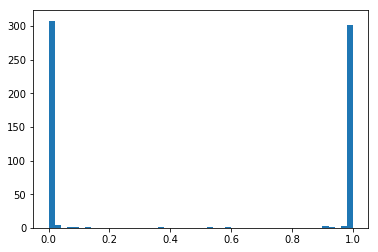

,Cutoff,Precision,Accuracy,F1,Recall
0,labels_gen_4,0.623693,0.4896,0.528804,0.458974
1,labels_gen_5,0.623693,0.4896,0.528804,0.458974
2,labels_gen_6,0.623693,0.4896,0.528804,0.458974
3,labels_gen_7,0.623693,0.4896,0.528804,0.458974
4,labels_gen_8,0.623693,0.4896,0.528804,0.458974
5,labels_gen_9,0.623693,0.4896,0.528804,0.458974


In [13]:
### Train generative model
train_5 = sparse.csr_matrix(Label_Matrix_to_GM.values)
GM_5 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
train_5_marginals = GM_5.marginals(train_5)
train_5_marginals.shape
plt.hist(train_5_marginals, bins=50)
plt.show()
train_5_marginals_df=pd.DataFrame(train_5_marginals)
train_5_marginals_df.columns=['train_5_marginals']
train_5_marginals_df=pd.DataFrame(train_5_marginals)
train_5_marginals_df.columns=['train_5_marginals']
Label_Gen_5=Gen_Label_Cutoff(train_5_marginals_df,'train_5_marginals')
Accuracy_Metric_GM_5=calculate_accuracy_GM(Label_Gen_5,Final_df,'target')
Accuracy_Metric_GM_5

## Second Experiment with 10 features

In [14]:
### Create Label Matrix
Label_df_10=labelGeneratorWithProbDist(Final_df,nCol=10,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_10=Label_df_10.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_10=tempdf_10.columns[tempdf_10.isna().any()].tolist()
## Drop these cols
Label_df_10 = Label_df_10.drop(cols_2_labels_10, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_10=calculate_accuracy_metric(Label_df_10,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_10=Label_Accuracy_Metric_10[Label_Accuracy_Metric_10['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_10=Label_df_10[Label_to_GM_10]
Label_Accuracy_Metric_10.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
49,ProbDist_8_ColumnR_19104,0.9856,0.717042,0.579221,0.640805,0.594156
48,ProbDist_7_Column_19104,0.9856,0.531148,0.420779,0.469565,0.405844
21,ProbDist_8_ColumnR_60036,0.9520,0.754266,0.589333,0.661677,0.620168
20,ProbDist_7_Column_60036,0.9520,0.509934,0.410667,0.454948,0.379832
62,ProbDist_3_Column_84405,0.9504,0.744898,0.591892,0.659639,0.619529
66,ProbDist_7_Column_84405,0.9504,0.744898,0.591892,0.659639,0.619529
63,ProbDist_4_ColumnR_84405,0.9504,0.503333,0.408108,0.450746,0.380471
67,ProbDist_8_ColumnR_84405,0.9504,0.503333,0.408108,0.450746,0.380471
3,ProbDist_4_ColumnR_39283,0.9472,0.750000,0.611413,0.673653,0.631757
2,ProbDist_3_Column_39283,0.9472,0.489726,0.388587,0.433333,0.368243


In [15]:
Label_Accuracy_Metric_10.head(10)
#Label_Matrix_to_GM_10.shape

,Label_Name,Coverage,Precision,Recall,F1,Accuracy
49,ProbDist_8_ColumnR_19104,0.9856,0.717042,0.579221,0.640805,0.594156
48,ProbDist_7_Column_19104,0.9856,0.531148,0.420779,0.469565,0.405844
21,ProbDist_8_ColumnR_60036,0.9520,0.754266,0.589333,0.661677,0.620168
20,ProbDist_7_Column_60036,0.9520,0.509934,0.410667,0.454948,0.379832
62,ProbDist_3_Column_84405,0.9504,0.744898,0.591892,0.659639,0.619529
66,ProbDist_7_Column_84405,0.9504,0.744898,0.591892,0.659639,0.619529
63,ProbDist_4_ColumnR_84405,0.9504,0.503333,0.408108,0.450746,0.380471
67,ProbDist_8_ColumnR_84405,0.9504,0.503333,0.408108,0.450746,0.380471
3,ProbDist_4_ColumnR_39283,0.9472,0.750000,0.611413,0.673653,0.631757
2,ProbDist_3_Column_39283,0.9472,0.489726,0.388587,0.433333,0.368243


Inferred cardinality: 2


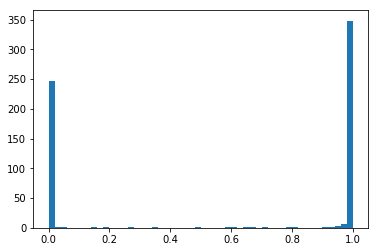

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.685131,0.5792,0.641201,0.602564
4,labels_gen_8,0.684058,0.5792,0.642177,0.605128
3,labels_gen_7,0.682997,0.5792,0.643148,0.607692
0,labels_gen_4,0.681818,0.5808,0.646900,0.615385
1,labels_gen_5,0.680912,0.5792,0.645074,0.612821
2,labels_gen_6,0.680912,0.5792,0.645074,0.612821


In [16]:
### Train generative model
train_10 = sparse.csr_matrix(Label_Matrix_to_GM_10.values)
GM_10 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_10.train(Label_Matrix_to_GM_10.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_10.values.T.shape[1], reg_param=1e-6)
train_10_marginals = GM_10.marginals(train_10)
train_10_marginals.shape
plt.hist(train_10_marginals, bins=50)
plt.show()
train_10_marginals_df=pd.DataFrame(train_10_marginals)
train_10_marginals_df.columns=['train_10_marginals']
train_10_marginals_df=pd.DataFrame(train_10_marginals)
train_10_marginals_df.columns=['train_10_marginals']
Label_Gen_10=Gen_Label_Cutoff(train_10_marginals_df,'train_10_marginals')
Accuracy_Metric_GM_10=calculate_accuracy_GM(Label_Gen_10,Final_df,'target')
Accuracy_Metric_GM_10

## Second Experiment with 15 features

In [17]:
### Create Label Matrix
Label_df_15=labelGeneratorWithProbDist(Final_df,nCol=15,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_15=Label_df_15.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_15=tempdf_15.columns[tempdf_15.isna().any()].tolist()
## Drop these cols
Label_df_15 = Label_df_15.drop(cols_2_labels_15, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_15=calculate_accuracy_metric(Label_df_15,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_15=Label_Accuracy_Metric_15[Label_Accuracy_Metric_15['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_15=Label_df_15[Label_to_GM_15]
Label_Accuracy_Metric_15.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
26,ProbDist_7_Column_109500,0.9856,0.754839,0.607792,0.673381,0.631494
27,ProbDist_8_ColumnR_109500,0.9856,0.493464,0.392208,0.437048,0.368506
36,ProbDist_3_Column_124796,0.9840,0.736334,0.599476,0.660895,0.617886
40,ProbDist_7_Column_124796,0.9840,0.736334,0.599476,0.660895,0.617886
101,ProbDist_8_ColumnR_86879,0.9840,0.651613,0.526042,0.582133,0.528455
69,ProbDist_8_ColumnR_73706,0.9840,0.642623,0.509091,0.568116,0.515447
68,ProbDist_7_Column_73706,0.9840,0.609677,0.490909,0.543885,0.484553
100,ProbDist_7_Column_86879,0.9840,0.596721,0.473958,0.528302,0.471545
37,ProbDist_4_ColumnR_124796,0.9840,0.503289,0.400524,0.446064,0.382114
41,ProbDist_8_ColumnR_124796,0.9840,0.503289,0.400524,0.446064,0.382114


Inferred cardinality: 2


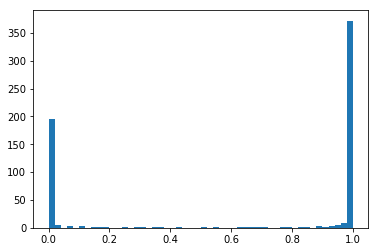

,Cutoff,Precision,Accuracy,F1,Recall
3,labels_gen_7,0.630542,0.5456,0.643216,0.656410
5,labels_gen_9,0.630380,0.5408,0.634395,0.638462
4,labels_gen_8,0.630273,0.5440,0.640605,0.651282
1,labels_gen_5,0.630170,0.5472,0.646692,0.664103
2,labels_gen_6,0.630170,0.5472,0.646692,0.664103
0,labels_gen_4,0.629540,0.5472,0.647572,0.666667


In [18]:
### Train generative model
train_15 = sparse.csr_matrix(Label_Matrix_to_GM_15.values)
GM_15 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_15.train(Label_Matrix_to_GM_15.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_15.values.T.shape[1], reg_param=1e-6)
train_15_marginals = GM_15.marginals(train_15)
train_15_marginals.shape
plt.hist(train_15_marginals, bins=50)
plt.show()
train_15_marginals_df=pd.DataFrame(train_15_marginals)
train_15_marginals_df.columns=['train_15_marginals']
train_15_marginals_df=pd.DataFrame(train_15_marginals)
train_15_marginals_df.columns=['train_15_marginals']
Label_Gen_15=Gen_Label_Cutoff(train_15_marginals_df,'train_15_marginals')
Accuracy_Metric_GM_15=calculate_accuracy_GM(Label_Gen_15,Final_df,'target')
Accuracy_Metric_GM_15

## Second Experiment with 20 features

In [19]:
### Create Label Matrix
Label_df_20=labelGeneratorWithProbDist(Final_df,nCol=20,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_20=Label_df_20.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_20=tempdf_20.columns[tempdf_20.isna().any()].tolist()
## Drop these cols
Label_df_20 = Label_df_20.drop(cols_2_labels_20, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_20=calculate_accuracy_metric(Label_df_20,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_20=Label_Accuracy_Metric_20[Label_Accuracy_Metric_20['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_20=Label_df_20[Label_to_GM_20]
Label_Accuracy_Metric_20.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
84,ProbDist_7_Column_89090,0.9888,0.798046,0.636364,0.708092,0.673139
46,ProbDist_7_Column_110920,0.9888,0.704545,0.560724,0.624460,0.577670
47,ProbDist_8_ColumnR_110920,0.9888,0.548387,0.439276,0.487805,0.422330
85,ProbDist_8_ColumnR_89090,0.9888,0.450161,0.363636,0.402299,0.326861
53,ProbDist_8_ColumnR_30737,0.9840,0.762058,0.620419,0.683983,0.643902
52,ProbDist_7_Column_30737,0.9840,0.476974,0.379581,0.422741,0.356098
88,ProbDist_3_Column_52956,0.9824,0.786408,0.634465,0.702312,0.664495
89,ProbDist_4_ColumnR_52956,0.9824,0.459016,0.365535,0.406977,0.335505
5,ProbDist_8_ColumnR_135290,0.9760,0.627451,0.505263,0.559767,0.504918
4,ProbDist_7_Column_135290,0.9760,0.618421,0.494737,0.549708,0.495082


Inferred cardinality: 2


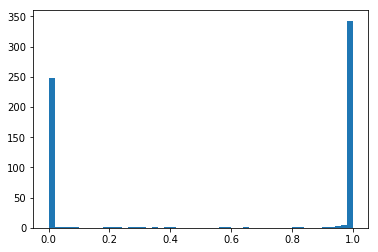

,Cutoff,Precision,Accuracy,F1,Recall
0,labels_gen_4,0.628499,0.5376,0.630907,0.633333
1,labels_gen_5,0.627551,0.5360,0.629156,0.630769
2,labels_gen_6,0.625641,0.5328,0.625641,0.625641
3,labels_gen_7,0.625641,0.5328,0.625641,0.625641
4,labels_gen_8,0.625641,0.5328,0.625641,0.625641
5,labels_gen_9,0.625323,0.5312,0.622909,0.620513


In [20]:
### Train generative model
train_20 = sparse.csr_matrix(Label_Matrix_to_GM_20.values)
GM_20 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_20.train(Label_Matrix_to_GM_20.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_20.values.T.shape[1], reg_param=1e-6)
train_20_marginals = GM_20.marginals(train_20)
train_20_marginals.shape
plt.hist(train_20_marginals, bins=50)
plt.show()
train_20_marginals_df=pd.DataFrame(train_20_marginals)
train_20_marginals_df.columns=['train_20_marginals']
train_20_marginals_df=pd.DataFrame(train_20_marginals)
train_20_marginals_df.columns=['train_20_marginals']
Label_Gen_20=Gen_Label_Cutoff(train_20_marginals_df,'train_20_marginals')
Accuracy_Metric_GM_20=calculate_accuracy_GM(Label_Gen_20,Final_df,'target')
Accuracy_Metric_GM_20

### Fifth Experiment with 25 features

In [21]:
### Create Label Matrix
Label_df_25=labelGeneratorWithProbDist(Final_df,nCol=25,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_25=Label_df_25.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_25=tempdf_25.columns[tempdf_25.isna().any()].tolist()
## Drop these cols
Label_df_25 = Label_df_25.drop(cols_2_labels_25, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_25=calculate_accuracy_metric(Label_df_25,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_25=Label_Accuracy_Metric_25[Label_Accuracy_Metric_25['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_25=Label_df_25[Label_to_GM_25]
Label_Accuracy_Metric_25.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
102,ProbDist_7_Column_76297,0.9888,0.762058,0.617188,0.682014,0.642395
103,ProbDist_8_ColumnR_76297,0.9888,0.478827,0.382812,0.425470,0.357605
37,ProbDist_8_ColumnR_2446,0.9840,0.691558,0.559055,0.618287,0.572358
36,ProbDist_7_Column_2446,0.9840,0.547231,0.440945,0.488372,0.427642
96,ProbDist_7_Column_147643,0.9824,0.672078,0.540470,0.599132,0.548860
97,ProbDist_8_ColumnR_147643,0.9824,0.575163,0.459530,0.510885,0.451140
138,ProbDist_3_Column_109989,0.9776,0.743421,0.591623,0.658892,0.617021
142,ProbDist_7_Column_109989,0.9776,0.743421,0.591623,0.658892,0.617021
139,ProbDist_4_ColumnR_109989,0.9776,0.508143,0.408377,0.452830,0.382979
143,ProbDist_8_ColumnR_109989,0.9776,0.508143,0.408377,0.452830,0.382979


Inferred cardinality: 2


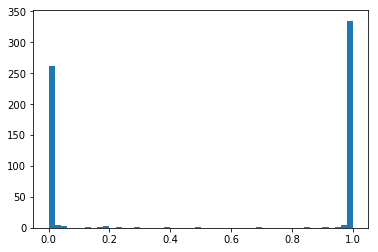

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.694444,0.5776,0.630252,0.576923
1,labels_gen_5,0.694190,0.5792,0.633194,0.582051
2,labels_gen_6,0.694190,0.5792,0.633194,0.582051
3,labels_gen_7,0.694190,0.5792,0.633194,0.582051
4,labels_gen_8,0.694190,0.5792,0.633194,0.582051
0,labels_gen_4,0.693009,0.5792,0.634214,0.584615


In [22]:
### Train generative model
train_25 = sparse.csr_matrix(Label_Matrix_to_GM_25.values)
GM_25 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_25.train(Label_Matrix_to_GM_25.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_25.values.T.shape[1], reg_param=1e-6)
train_25_marginals = GM_25.marginals(train_25)
train_25_marginals.shape
plt.hist(train_25_marginals, bins=50)
plt.show()
train_25_marginals_df=pd.DataFrame(train_25_marginals)
train_25_marginals_df.columns=['train_25_marginals']
train_25_marginals_df=pd.DataFrame(train_25_marginals)
train_25_marginals_df.columns=['train_25_marginals']
Label_Gen_25=Gen_Label_Cutoff(train_25_marginals_df,'train_25_marginals')
Accuracy_Metric_GM_25=calculate_accuracy_GM(Label_Gen_25,Final_df,'target')
Accuracy_Metric_GM_25

### Sixth Experiment with 30 features

In [23]:
### Create Label Matrix
Label_df_30=labelGeneratorWithProbDist(Final_df,nCol=30,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_30=Label_df_30.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_30=tempdf_30.columns[tempdf_30.isna().any()].tolist()
## Drop these cols
Label_df_30 = Label_df_30.drop(cols_2_labels_30, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_30=calculate_accuracy_metric(Label_df_30,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_30=Label_Accuracy_Metric_30[Label_Accuracy_Metric_30['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_30=Label_df_30[Label_to_GM_30]
Label_Accuracy_Metric_30.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
127,ProbDist_8_ColumnR_11689,0.9920,0.689320,0.548969,0.611191,0.562903
126,ProbDist_7_Column_11689,0.9920,0.562701,0.451031,0.500715,0.437097
185,ProbDist_8_ColumnR_9675,0.9808,0.710526,0.562500,0.627907,0.582382
184,ProbDist_7_Column_9675,0.9808,0.543689,0.437500,0.484848,0.417618
135,ProbDist_8_ColumnR_5256,0.9760,0.718033,0.574803,0.638484,0.593443
134,ProbDist_7_Column_5256,0.9760,0.531148,0.425197,0.472303,0.406557
3,ProbDist_4_ColumnR_148720,0.9696,0.743333,0.591512,0.658789,0.618812
2,ProbDist_3_Column_148720,0.9696,0.503268,0.408488,0.450952,0.381188
66,ProbDist_3_Column_104946,0.9648,0.759076,0.611702,0.677467,0.636816
67,ProbDist_4_ColumnR_104946,0.9648,0.486667,0.388298,0.431953,0.363184


Inferred cardinality: 2


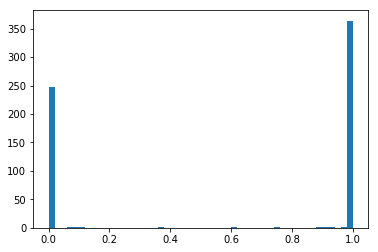

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.667553,0.5776,0.655352,0.643590
0,labels_gen_4,0.666667,0.5776,0.656250,0.646154
1,labels_gen_5,0.666667,0.5776,0.656250,0.646154
2,labels_gen_6,0.666667,0.5776,0.656250,0.646154
3,labels_gen_7,0.666667,0.5776,0.656250,0.646154
4,labels_gen_8,0.666667,0.5776,0.656250,0.646154


In [24]:
### Train generative model
train_30 = sparse.csr_matrix(Label_Matrix_to_GM_30.values)
GM_30 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_30.train(Label_Matrix_to_GM_30.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_30.values.T.shape[1], reg_param=1e-6)
train_30_marginals = GM_30.marginals(train_30)
train_30_marginals.shape
plt.hist(train_30_marginals, bins=50)
plt.show()
train_30_marginals_df=pd.DataFrame(train_30_marginals)
train_30_marginals_df.columns=['train_30_marginals']
train_30_marginals_df=pd.DataFrame(train_30_marginals)
train_30_marginals_df.columns=['train_30_marginals']
Label_Gen_30=Gen_Label_Cutoff(train_30_marginals_df,'train_30_marginals')
Accuracy_Metric_GM_30=calculate_accuracy_GM(Label_Gen_30,Final_df,'target')
Accuracy_Metric_GM_30

### Sixth Experiment with 35 features

In [25]:
### Create Label Matrix
Label_df_35=labelGeneratorWithProbDist(Final_df,nCol=35,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_35=Label_df_35.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_35=tempdf_35.columns[tempdf_35.isna().any()].tolist()
## Drop these cols
Label_df_35 = Label_df_35.drop(cols_2_labels_35, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_35=calculate_accuracy_metric(Label_df_35,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_35=Label_Accuracy_Metric_35[Label_Accuracy_Metric_35['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_35=Label_df_35[Label_to_GM_35]
Label_Accuracy_Metric_35.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
204,ProbDist_7_Column_91486,0.9888,0.787582,0.622739,0.695527,0.658576
163,ProbDist_8_ColumnR_14908,0.9888,0.683871,0.549223,0.609195,0.559871
162,ProbDist_7_Column_14908,0.9888,0.564935,0.450777,0.501441,0.440129
205,ProbDist_8_ColumnR_91486,0.9888,0.467949,0.377261,0.417740,0.341424
157,ProbDist_8_ColumnR_49270,0.9856,0.770492,0.611979,0.682148,0.644481
245,ProbDist_8_ColumnR_84082,0.9856,0.628664,0.500000,0.556999,0.501623
244,ProbDist_7_Column_84082,0.9856,0.624595,0.500000,0.555396,0.498377
156,ProbDist_7_Column_49270,0.9856,0.479100,0.388021,0.428777,0.355519
221,ProbDist_8_ColumnR_33936,0.9824,0.754045,0.609948,0.674385,0.633550
220,ProbDist_7_Column_33936,0.9824,0.488525,0.390052,0.433770,0.366450


Inferred cardinality: 2


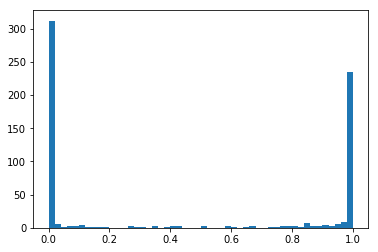

,Cutoff,Precision,Accuracy,F1,Recall
2,labels_gen_6,0.548077,0.4240,0.487179,0.438462
1,labels_gen_5,0.547468,0.4240,0.490085,0.443590
3,labels_gen_7,0.547231,0.4224,0.482066,0.430769
0,labels_gen_4,0.547170,0.4240,0.491525,0.446154
4,labels_gen_8,0.546667,0.4208,0.475362,0.420513
5,labels_gen_9,0.542857,0.4144,0.453731,0.389744


In [26]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
train_35 = sparse.csr_matrix(Label_Matrix_to_GM_35.values)
GM_35 = GenerativeModel()
GM_35.train(Label_Matrix_to_GM_35.values, epochs=1000, decay=0.7, step_size= 0.1/ Label_Matrix_to_GM_35.values.T.shape[1], reg_param=1e-6)
train_35_marginals = GM_35.marginals(train_35)
train_35_marginals.shape
plt.hist(train_35_marginals, bins=50)
plt.show()
train_35_marginals_df=pd.DataFrame(train_35_marginals)
train_35_marginals_df.columns=['train_35_marginals']
train_35_marginals_df=pd.DataFrame(train_35_marginals)
train_35_marginals_df.columns=['train_35_marginals']
Label_Gen_35=Gen_Label_Cutoff(train_35_marginals_df,'train_35_marginals')
Accuracy_Metric_GM_35=calculate_accuracy_GM(Label_Gen_35,Final_df,'target')
Accuracy_Metric_GM_35

### Sixth Experiment with 40 features

In [27]:
### Create Label Matrix
Label_df_40=labelGeneratorWithProbDist(Final_df,nCol=40,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_40=Label_df_40.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_40=tempdf_40.columns[tempdf_40.isna().any()].tolist()
## Drop these cols
Label_df_40 = Label_df_40.drop(cols_2_labels_40, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_40=calculate_accuracy_metric(Label_df_40,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_40=Label_Accuracy_Metric_40[Label_Accuracy_Metric_40['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_40=Label_df_40[Label_to_GM_40]
Label_Accuracy_Metric_40.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
103,ProbDist_8_ColumnR_29933,0.9952,0.761290,0.606684,0.675250,0.635048
102,ProbDist_7_Column_29933,0.9952,0.490385,0.393316,0.436519,0.364952
273,ProbDist_8_ColumnR_16100,0.9904,0.689103,0.556995,0.616046,0.567044
272,ProbDist_7_Column_16100,0.9904,0.557003,0.443005,0.493506,0.432956
206,ProbDist_7_Column_50247,0.9888,0.785016,0.625974,0.696532,0.660194
42,ProbDist_7_Column_125489,0.9888,0.737179,0.594315,0.658083,0.613269
6,ProbDist_7_Column_103514,0.9888,0.737013,0.585052,0.652299,0.608414
7,ProbDist_8_ColumnR_103514,0.9888,0.519355,0.414948,0.461318,0.391586
43,ProbDist_8_ColumnR_125489,0.9888,0.513072,0.405685,0.453102,0.386731
207,ProbDist_8_ColumnR_50247,0.9888,0.463023,0.374026,0.413793,0.339806


Inferred cardinality: 2


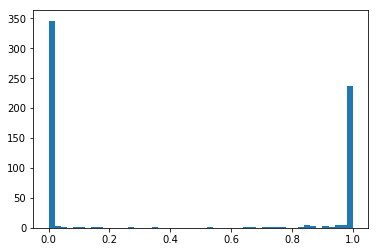

,Cutoff,Precision,Accuracy,F1,Recall
3,labels_gen_7,0.559322,0.4320,0.481752,0.423077
0,labels_gen_4,0.558528,0.4320,0.484761,0.428205
1,labels_gen_5,0.558528,0.4320,0.484761,0.428205
2,labels_gen_6,0.558528,0.4320,0.484761,0.428205
5,labels_gen_9,0.555160,0.4256,0.464978,0.400000
4,labels_gen_8,0.553633,0.4256,0.471281,0.410256


In [28]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_40 = sparse.csr_matrix(Label_Matrix_to_GM_40.values)
GM_40 = GenerativeModel()
GM_40.train(Label_Matrix_to_GM_40.values, epochs=1000, decay=0.8, step_size= 0.1/ Label_Matrix_to_GM_40.values.T.shape[1], reg_param=1e-6)
train_40_marginals = GM_40.marginals(train_40)
train_40_marginals.shape
plt.hist(train_40_marginals, bins=50)
plt.show()
train_40_marginals_df=pd.DataFrame(train_40_marginals)
train_40_marginals_df.columns=['train_40_marginals']
train_40_marginals_df=pd.DataFrame(train_40_marginals)
train_40_marginals_df.columns=['train_40_marginals']
Label_Gen_40=Gen_Label_Cutoff(train_40_marginals_df,'train_40_marginals')
Accuracy_Metric_GM_40=calculate_accuracy_GM(Label_Gen_40,Final_df,'target')
Accuracy_Metric_GM_40

### Sixth Experiment with 45 features

### Sixth Experiment with 45 features

In [29]:
### Create Label Matrix
Label_df_45=labelGeneratorWithProbDist(Final_df,nCol=45,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_45=Label_df_45.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_45=tempdf_45.columns[tempdf_45.isna().any()].tolist()
## Drop these cols
Label_df_45 = Label_df_45.drop(cols_2_labels_45, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_45=calculate_accuracy_metric(Label_df_45,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_45=Label_Accuracy_Metric_45[Label_Accuracy_Metric_45['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_45=Label_df_45[Label_to_GM_45]
Label_Accuracy_Metric_45.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
42,ProbDist_7_Column_124928,0.9968,0.678457,0.542416,0.602857,0.553772
43,ProbDist_8_ColumnR_124928,0.9968,0.570513,0.457584,0.507846,0.446228
199,ProbDist_8_ColumnR_150733,0.9888,0.735484,0.590674,0.655172,0.611650
125,ProbDist_8_ColumnR_138713,0.9888,0.640523,0.509091,0.567294,0.516181
124,ProbDist_7_Column_138713,0.9888,0.605769,0.490909,0.542324,0.483819
198,ProbDist_7_Column_150733,0.9888,0.512987,0.409326,0.455331,0.388350
222,ProbDist_3_Column_147993,0.9872,0.740385,0.601562,0.663793,0.620746
226,ProbDist_7_Column_147993,0.9872,0.740385,0.601562,0.663793,0.620746
10,ProbDist_7_Column_13869,0.9872,0.629032,0.506494,0.561151,0.505673
11,ProbDist_8_ColumnR_13869,0.9872,0.618893,0.493506,0.549133,0.494327


Inferred cardinality: 2


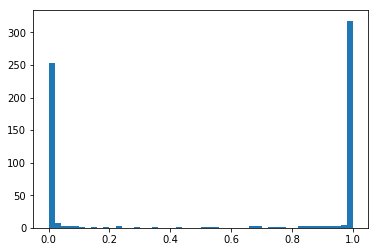

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.701863,0.5840,0.634831,0.579487
4,labels_gen_8,0.699088,0.5856,0.639777,0.589744
3,labels_gen_7,0.696697,0.5856,0.641770,0.594872
2,labels_gen_6,0.696165,0.5888,0.647462,0.605128
0,labels_gen_4,0.695015,0.5888,0.648427,0.607692
1,labels_gen_5,0.695015,0.5888,0.648427,0.607692


In [30]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_45 = sparse.csr_matrix(Label_Matrix_to_GM_45.values)
GM_45 = GenerativeModel()
GM_45.train(Label_Matrix_to_GM_45.values, epochs=1000, decay=0.8, step_size= 0.07/ Label_Matrix_to_GM_45.values.T.shape[1], reg_param=1e-6)
train_45_marginals = GM_45.marginals(train_45)
train_45_marginals.shape
plt.hist(train_45_marginals, bins=50)
plt.show()
train_45_marginals_df=pd.DataFrame(train_45_marginals)
train_45_marginals_df.columns=['train_45_marginals']
train_45_marginals_df=pd.DataFrame(train_45_marginals)
train_45_marginals_df.columns=['train_45_marginals']
Label_Gen_45=Gen_Label_Cutoff(train_45_marginals_df,'train_45_marginals')
Accuracy_Metric_GM_45=calculate_accuracy_GM(Label_Gen_45,Final_df,'target')
Accuracy_Metric_GM_45

### Sixth Experiment with 50 features

In [31]:
### Create Label Matrix
Label_df_50=labelGeneratorWithProbDist(Final_df,nCol=50,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_50=Label_df_50.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_50=tempdf_50.columns[tempdf_50.isna().any()].tolist()
## Drop these cols
Label_df_50 = Label_df_50.drop(cols_2_labels_50, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_50=calculate_accuracy_metric(Label_df_50,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_50=Label_Accuracy_Metric_50[Label_Accuracy_Metric_50['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_50=Label_df_50[Label_to_GM_50]
Label_Accuracy_Metric_50.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
240,ProbDist_7_Column_137278,0.9936,0.627010,0.502577,0.557940,0.502415
241,ProbDist_8_ColumnR_137278,0.9936,0.622581,0.497423,0.553009,0.497585
298,ProbDist_7_Column_76689,0.9904,0.779935,0.624352,0.693525,0.655897
124,ProbDist_7_Column_112123,0.9904,0.733974,0.594805,0.657102,0.613893
305,ProbDist_8_ColumnR_80861,0.9904,0.729642,0.580311,0.646465,0.604200
164,ProbDist_7_Column_125723,0.9904,0.666667,0.532300,0.591954,0.541195
202,ProbDist_7_Column_136467,0.9904,0.662379,0.532300,0.590258,0.537964
203,ProbDist_8_ColumnR_136467,0.9904,0.587662,0.467700,0.520863,0.462036
165,ProbDist_8_ColumnR_125723,0.9904,0.583871,0.467700,0.519369,0.458805
304,ProbDist_7_Column_80861,0.9904,0.519231,0.419689,0.464183,0.395800


Inferred cardinality: 2


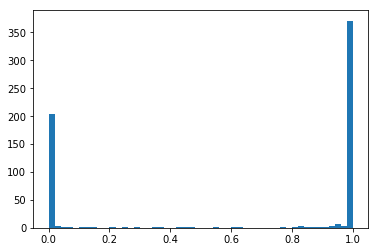

,Cutoff,Precision,Accuracy,F1,Recall
4,labels_gen_8,0.623529,0.5440,0.650307,0.679487
5,labels_gen_9,0.623501,0.5408,0.644362,0.666667
3,labels_gen_7,0.622951,0.5440,0.651163,0.682051
2,labels_gen_6,0.622378,0.5440,0.652015,0.684615
1,labels_gen_5,0.621810,0.5440,0.652862,0.687179
0,labels_gen_4,0.621560,0.5456,0.656174,0.694872


In [32]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_50 = sparse.csr_matrix(Label_Matrix_to_GM_50.values)
GM_50 = GenerativeModel()
GM_50.train(Label_Matrix_to_GM_50.values, epochs=1000, decay=0.8, step_size= 0.07/ Label_Matrix_to_GM_50.values.T.shape[1], reg_param=1e-6)
train_50_marginals = GM_50.marginals(train_50)
train_50_marginals.shape
plt.hist(train_50_marginals, bins=50)
plt.show()
train_50_marginals_df=pd.DataFrame(train_50_marginals)
train_50_marginals_df.columns=['train_50_marginals']
train_50_marginals_df=pd.DataFrame(train_50_marginals)
train_50_marginals_df.columns=['train_50_marginals']
Label_Gen_50=Gen_Label_Cutoff(train_50_marginals_df,'train_50_marginals')
Accuracy_Metric_GM_50=calculate_accuracy_GM(Label_Gen_50,Final_df,'target')
Accuracy_Metric_GM_50

### Sixth Experiment with 55 features

In [33]:
### Create Label Matrix
Label_df_55=labelGeneratorWithProbDist(Final_df,nCol=55,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_55=Label_df_55.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_55=tempdf_55.columns[tempdf_55.isna().any()].tolist()
## Drop these cols
Label_df_55 = Label_df_55.drop(cols_2_labels_55, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_55=calculate_accuracy_metric(Label_df_55,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_55=Label_Accuracy_Metric_55[Label_Accuracy_Metric_55['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_55=Label_df_55[Label_to_GM_55]
Label_Accuracy_Metric_55.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
88,ProbDist_3_Column_114794,0.9920,0.735484,0.590674,0.655172,0.612903
92,ProbDist_7_Column_114794,0.9920,0.735484,0.590674,0.655172,0.612903
89,ProbDist_4_ColumnR_114794,0.9920,0.509677,0.409326,0.454023,0.387097
93,ProbDist_8_ColumnR_114794,0.9920,0.509677,0.409326,0.454023,0.387097
368,ProbDist_7_Column_126116,0.9904,0.676375,0.540052,0.600575,0.550889
369,ProbDist_8_ColumnR_126116,0.9904,0.574194,0.459948,0.510760,0.449111
108,ProbDist_7_Column_98880,0.9872,0.629508,0.496124,0.554913,0.500810
109,ProbDist_8_ColumnR_98880,0.9872,0.625000,0.503876,0.557940,0.499190
21,ProbDist_8_ColumnR_11678,0.9856,0.719870,0.578534,0.641509,0.599026
61,ProbDist_8_ColumnR_89657,0.9856,0.711538,0.576623,0.637016,0.589286


Inferred cardinality: 2


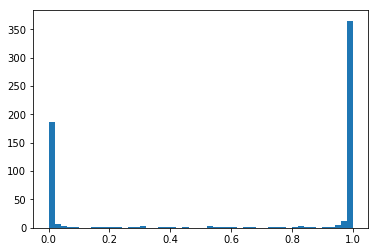

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.676630,0.5840,0.656992,0.638462
4,labels_gen_8,0.671958,0.5840,0.661458,0.651282
3,labels_gen_7,0.669271,0.5840,0.664083,0.658974
2,labels_gen_6,0.665816,0.5840,0.667519,0.669231
0,labels_gen_4,0.660147,0.5856,0.675845,0.692308
1,labels_gen_5,0.660099,0.5840,0.673367,0.687179


In [34]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_55 = sparse.csr_matrix(Label_Matrix_to_GM_55.values)
GM_55 = GenerativeModel()
GM_55.train(Label_Matrix_to_GM_55.values, epochs=1000, decay=0.7, step_size= 0.07/ Label_Matrix_to_GM_55.values.T.shape[1], reg_param=1e-6)
train_55_marginals = GM_55.marginals(train_55)
train_55_marginals.shape
plt.hist(train_55_marginals, bins=50)
plt.show()
train_55_marginals_df=pd.DataFrame(train_55_marginals)
train_55_marginals_df.columns=['train_55_marginals']
train_55_marginals_df=pd.DataFrame(train_55_marginals)
train_55_marginals_df.columns=['train_55_marginals']
Label_Gen_55=Gen_Label_Cutoff(train_55_marginals_df,'train_55_marginals')
Accuracy_Metric_GM_55=calculate_accuracy_GM(Label_Gen_55,Final_df,'target')
Accuracy_Metric_GM_55

### Expereiment with 100 features

In [35]:
### Create Label Matrix
Label_df_100=labelGeneratorWithProbDist(Final_df,nCol=100,pctCutoff=0.08)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_100=Label_df_100.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_100=tempdf_100.columns[tempdf_100.isna().any()].tolist()
## Drop these cols
Label_df_100 = Label_df_100.drop(cols_2_labels_100, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_100=calculate_accuracy_metric(Label_df_100,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_100=Label_Accuracy_Metric_100[Label_Accuracy_Metric_100['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_100=Label_df_100[Label_to_GM_100]
Label_Accuracy_Metric_100.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
474,ProbDist_7_Column_43044,0.9952,0.755627,0.607235,0.673352,0.633441
308,ProbDist_7_Column_89107,0.9952,0.739550,0.591260,0.657143,0.614148
309,ProbDist_8_ColumnR_89107,0.9952,0.511254,0.408740,0.454286,0.385852
475,ProbDist_8_ColumnR_43044,0.9952,0.488746,0.392765,0.435530,0.366559
252,ProbDist_3_Column_144790,0.9936,0.730769,0.589147,0.652361,0.608696
256,ProbDist_7_Column_144790,0.9936,0.730769,0.589147,0.652361,0.608696
253,ProbDist_4_ColumnR_144790,0.9936,0.514563,0.410853,0.456897,0.391304
257,ProbDist_8_ColumnR_144790,0.9936,0.514563,0.410853,0.456897,0.391304
93,ProbDist_8_ColumnR_56863,0.9920,0.782468,0.619537,0.691535,0.653226
79,ProbDist_8_ColumnR_21529,0.9920,0.766990,0.613990,0.682014,0.643548


Inferred cardinality: 2


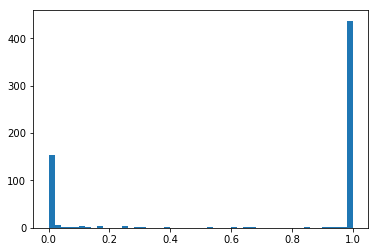

,Cutoff,Precision,Accuracy,F1,Recall
2,labels_gen_6,0.632829,0.5728,0.686987,0.751282
3,labels_gen_7,0.632609,0.5712,0.684706,0.746154
4,labels_gen_8,0.632609,0.5712,0.684706,0.746154
0,labels_gen_4,0.631692,0.5728,0.688448,0.756410
1,labels_gen_5,0.631692,0.5728,0.688448,0.756410
5,labels_gen_9,0.631004,0.5680,0.681604,0.741026


In [36]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_100 = sparse.csr_matrix(Label_Matrix_to_GM_100.values)
GM_100 = GenerativeModel()
GM_100.train(Label_Matrix_to_GM_100.values, epochs=1000, decay=0.7, step_size= 0.07/ Label_Matrix_to_GM_100.values.T.shape[1], reg_param=1e-6)
train_100_marginals = GM_100.marginals(train_100)
train_100_marginals.shape
plt.hist(train_100_marginals, bins=50)
plt.show()
train_100_marginals_df=pd.DataFrame(train_100_marginals)
train_100_marginals_df.columns=['train_100_marginals']
train_100_marginals_df=pd.DataFrame(train_100_marginals)
train_100_marginals_df.columns=['train_100_marginals']
Label_Gen_100=Gen_Label_Cutoff(train_100_marginals_df,'train_100_marginals')
Accuracy_Metric_GM_100=calculate_accuracy_GM(Label_Gen_100,Final_df,'target')
Accuracy_Metric_GM_100

In [38]:
Label_Gen_100.to_csv("C:\\NICE\\TMF_DATA\\BITSPilani\\IITH\\Classess\\7.AdvancedML\\Project\\MidSem\\Data_To_Nimesh\\DataProgrammingLabel_Exp2.csv")

### Experiment Result Analysis

In [107]:
## Get the number of labels created by number of features used
label_df_list=[Label_Accuracy_Metric,Label_Accuracy_Metric_10,Label_Accuracy_Metric_15,Label_Accuracy_Metric_20,Label_Accuracy_Metric_25,Label_Accuracy_Metric_30,Label_Accuracy_Metric_35,Label_Accuracy_Metric_40,Label_Accuracy_Metric_45,Label_Accuracy_Metric_50,Label_Accuracy_Metric_55,Label_Accuracy_Metric_100]
label_Matrix=[Label_Matrix_to_GM,Label_Matrix_to_GM_10,Label_Matrix_to_GM_15,Label_Matrix_to_GM_20,Label_Matrix_to_GM_25,Label_Matrix_to_GM_30,Label_Matrix_to_GM_35,Label_Matrix_to_GM_40,Label_Matrix_to_GM_45,Label_Matrix_to_GM_50,Label_Matrix_to_GM_55,Label_Matrix_to_GM_100]
No_Feature_Used=[5,10,15,20,25,30,35,40,45,50,55,100]
No_Of_Labels_Generated=[]
label_matrix_gm=[]
for l in label_df_list:
    No_Of_Labels_Generated.append(l.shape[0])

for l in label_Matrix:
    label_matrix_gm.append(l.shape[1])
print(label_matrix_gm)
    
print(No_Of_Labels_Generated)
Input_Details=pd.concat([pd.DataFrame(No_Feature_Used),pd.DataFrame(No_Of_Labels_Generated),pd.DataFrame(label_matrix_gm)],axis=1)
Input_Details.columns=['No_Feature_Used','Total_No_Label_Generated','No_Label_To_GenerativeModel']
Input_Details

[30, 54, 70, 108, 116, 144, 190, 200, 248, 260, 286, 482]
[34, 68, 110, 134, 182, 210, 246, 280, 304, 346, 388, 696]


,No_Feature_Used,Total_No_Label_Generated,No_Label_To_GenerativeModel
0,5,34,30
1,10,68,54
2,15,110,70
3,20,134,108
4,25,182,116
5,30,210,144
6,35,246,190
7,40,280,200
8,45,304,248
9,50,346,260


In [108]:
## Getting Average accuracy statistics for each run
#Label_Accuracy_Metric.columns[1:]
Mean_Acc_Label=[]
for l in label_df_list:
    Mean_Acc_Label.append(l.mean().tolist())

Mean_Acc_Label_df=pd.DataFrame(Mean_Acc_Label)
Mean_Acc_Label_df.columns=Label_Accuracy_Metric.columns[1:]
temp=pd.DataFrame(No_Feature_Used)
temp.columns=['No_Feature_Used']
Mean_Acc_Label_df=pd.concat([temp,Mean_Acc_Label_df],axis=1)
Mean_Acc_Label_df

,No_Feature_Used,Coverage,Precision,Recall,F1,Accuracy
0,5,0.860047,0.592384,0.5,0.568782,0.5
1,10,0.725553,0.588080,0.5,0.528095,0.5
2,15,0.672000,0.596885,0.5,0.529309,0.5
3,20,0.790209,0.607225,0.5,0.534816,0.5
4,25,0.674338,0.591140,0.5,0.526903,0.5
5,30,0.690575,0.596399,0.5,0.536493,0.5
6,35,0.762433,0.595895,0.5,0.529482,0.5
7,40,0.716743,0.590553,0.5,0.536529,0.5
8,45,0.773242,0.608682,0.5,0.531026,0.5
9,50,0.741179,0.600036,0.5,0.531266,0.5


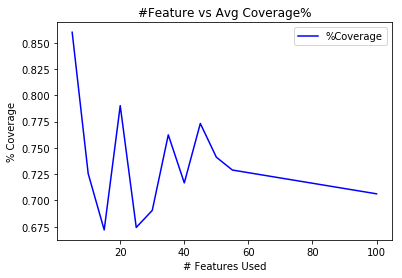

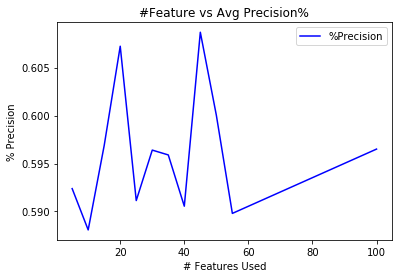

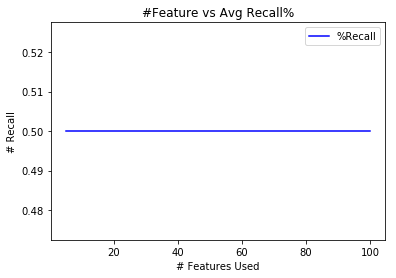

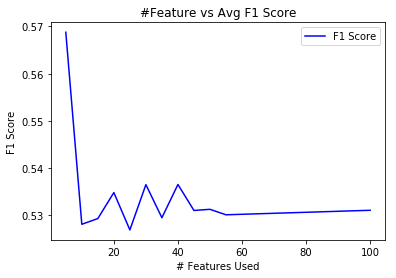

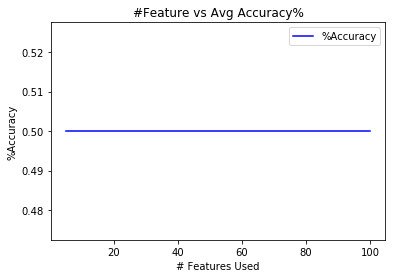

In [46]:
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Coverage'], color='blue',label='%Coverage')
plt.xlabel('# Features Used')
plt.ylabel('% Coverage')
plt.title('#Feature vs Avg Coverage%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Precision'], color='blue',label='%Precision')
plt.xlabel('# Features Used')
plt.ylabel('% Precision')
plt.title('#Feature vs Avg Precision%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Recall'], color='blue',label='%Recall')
plt.xlabel('# Features Used')
plt.ylabel('# Recall')
plt.title('#Feature vs Avg Recall%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['F1'], color='blue',label='F1 Score')
plt.xlabel('# Features Used')
plt.ylabel('F1 Score')
plt.title('#Feature vs Avg F1 Score')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Accuracy'], color='blue',label='%Accuracy')
plt.xlabel('# Features Used')
plt.ylabel('%Accuracy')
plt.title('#Feature vs Avg Accuracy%')
plt.legend()
plt.show()

In [42]:
## Generative Model performance @90% probability cut-off
Gen_Model_list=[Accuracy_Metric_GM_5,Accuracy_Metric_GM_10,Accuracy_Metric_GM_15,Accuracy_Metric_GM_20,Accuracy_Metric_GM_25,Accuracy_Metric_GM_30,Accuracy_Metric_GM_35,Accuracy_Metric_GM_40,Accuracy_Metric_GM_45,Accuracy_Metric_GM_50,Accuracy_Metric_GM_55,Accuracy_Metric_GM_100]
Gen_Model_Performance_df=pd.DataFrame()
for l in Gen_Model_list:
    Gen_Model_Performance_df=Gen_Model_Performance_df.append(l[l['Cutoff']=='labels_gen_9'])
Gen_Model_Performance_df


,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.623693,0.4896,0.528804,0.458974
5,labels_gen_9,0.685131,0.5792,0.641201,0.602564
5,labels_gen_9,0.630380,0.5408,0.634395,0.638462
5,labels_gen_9,0.625323,0.5312,0.622909,0.620513
5,labels_gen_9,0.694444,0.5776,0.630252,0.576923
5,labels_gen_9,0.667553,0.5776,0.655352,0.643590
5,labels_gen_9,0.542857,0.4144,0.453731,0.389744
5,labels_gen_9,0.555160,0.4256,0.464978,0.400000
5,labels_gen_9,0.701863,0.5840,0.634831,0.579487
5,labels_gen_9,0.623501,0.5408,0.644362,0.666667


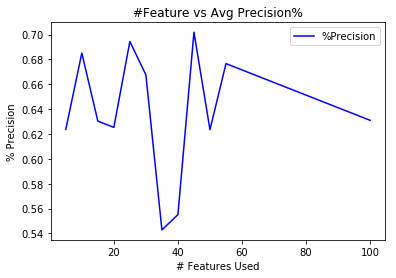

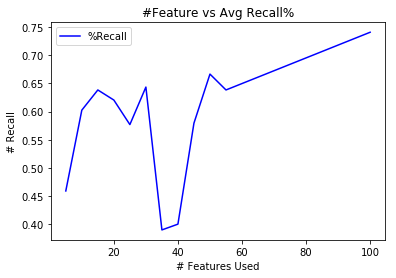

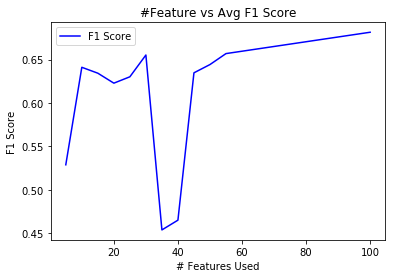

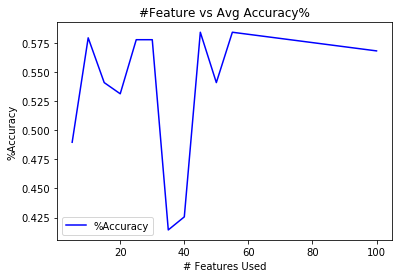

In [43]:
plt.plot(No_Feature_Used, Gen_Model_Performance_df['Precision'], color='blue',label='%Precision')
plt.xlabel('# Features Used')
plt.ylabel('% Precision')
plt.title('#Feature vs Avg Precision%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Gen_Model_Performance_df['Recall'], color='blue',label='%Recall')
plt.xlabel('# Features Used')
plt.ylabel('# Recall')
plt.title('#Feature vs Avg Recall%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Gen_Model_Performance_df['F1'], color='blue',label='F1 Score')
plt.xlabel('# Features Used')
plt.ylabel('F1 Score')
plt.title('#Feature vs Avg F1 Score')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Gen_Model_Performance_df['Accuracy'], color='blue',label='%Accuracy')
plt.xlabel('# Features Used')
plt.ylabel('%Accuracy')
plt.title('#Feature vs Avg Accuracy%')
plt.legend()
plt.show()